In [1]:
import daw_readout
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
#import h5py
from tqdm import trange
from tqdm import tqdm
#import time

import fit_package as ft
import plot_tools as pt
import analysis_data as ad

import process_data as prc

Develop an Algorithm to find the pulse which over threshold and calculate it's area and start time

In [2]:
f = 'runlist/tpc_4pmt_app_run_processed'
flist = ad.read_file_names(f)
df = ad.merge_files(flist)

# df = pd.read_hdf('/mnt/data/outnpy/r8520_4pmt_tpc_after_pulse_ext_low_temp_232K_Ch1415_20250627_run0_raw_b0_seg0.h5py')

df.head()

/mnt/data/outnpy/r8520_4pmt_tpc_after_pulse_ext_low_temp_232K_Ch1415_20250627_run0_raw_b0_seg0.h5py
/mnt/data/outnpy/tpc_2pmt_20250704_APP_run_raw_b0_seg0.h5py
/mnt/data/outnpy/tpc_2pmt_20250704_APP_run_raw_b0_seg1.h5py


,Ch,TTT,Baseline,Area,Hight,st,ed,md,width,WLen,Wave
0,14,1410376,8178,2705.627441,8178,111,125,118,14,1500,"[8175, 8177, 8174, 8176, 8180, 8178, 8176, 817..."
1,15,1410376,8148,3043.945313,8148,111,125,118,14,1500,"[8145, 8149, 8146, 8145, 8147, 8144, 8145, 814..."
2,14,6410344,8178,2710.510254,8178,108,122,115,14,1500,"[8179, 8178, 8179, 8175, 8180, 8180, 8180, 817..."
3,15,6410344,8147,2997.924805,8147,108,122,115,14,1500,"[8145, 8146, 8148, 8145, 8148, 8146, 8149, 814..."
4,14,11410308,8177,2527.648926,8177,109,123,116,14,1500,"[8180, 8174, 8173, 8178, 8180, 8175, 8174, 817..."


In [43]:
'''
import numpy as np
import pandas as pd
import logging

def findpulse_st_ed(waveform_data: np.ndarray, baseline: int, referencePoint: int):
    start_range = max(0, referencePoint - 5)
    end_range = min(len(waveform_data), referencePoint + 15)

    min_index = referencePoint
    min_value = waveform_data[referencePoint]
    for i in range(start_range, end_range):
        if waveform_data[i] < min_value:
            min_value = waveform_data[i]
            min_index = i

    start_index = min_index
    while start_index > start_range:
        if (waveform_data[start_index] - waveform_data[start_index - 1]) < 0:
            start_index -= 1
        else:
            break

    end_index = min_index
    if end_index + 1 < end_range and waveform_data[min_index] == waveform_data[end_index + 1]:
        end_index += 1

    while end_index + 1 < end_range:
        if (waveform_data[end_index + 1] - waveform_data[end_index]) > 0:
            end_index += 1
        else:
            break

    return start_index, min_index, end_index

def cal_area(waveform_data, st: int, ed: int, baseline: int):
    sum_val = np.sum(waveform_data[st: ed])
    area = baseline * (ed - st) - sum_val
    pe_fact = (2./16384)*4.e-9/(50*1.6e-19)/1.e6  # 转换系数
    return area * pe_fact

def filter_points(points, min_interval):
    filtered = []
    last_idx = None
    for idx in points:
        if last_idx is None or idx - last_idx >= min_interval:
            filtered.append(idx)
            last_idx = idx
    return filtered

def filter_after_pulses(df_after_pulse, min_interval=10):
    """
    过滤 after_pulse DataFrame 中 start 时间点间隔小于 min_interval 的行。
    如果两个 start 时间点间隔小于 min_interval，则滤除后一个时间点对应的行。
    
    参数:
        df_after_pulse: pandas.DataFrame，必须包含 'start' 列，且为数值类型。
        min_interval: int，最小间隔阈值，单位为样本数。
    
    返回:
        过滤后的 DataFrame。
    """
    # 先按 start 排序，确保顺序正确
    df_sorted = df_after_pulse.sort_values('start').reset_index(drop=True)
    
    # 用一个布尔列表标记哪些行保留，初始都保留
    keep = [True] * len(df_sorted)
    
    for i in range(1, len(df_sorted)):
        # 计算当前start与前一个start的差值
        diff = df_sorted.loc[i, 'start'] - df_sorted.loc[i-1, 'start']
        if diff < min_interval:
            # 间隔小于阈值，滤除当前行（i）
            keep[i] = False
    
    # 返回过滤后的 DataFrame
    return df_sorted[keep].reset_index(drop=True)

def filter_all_segments(df_after_pulse, min_interval=10):
    filtered_segments = []
    for segment_id, group_df in df_after_pulse.groupby('segment'):
        filtered_df = filter_after_pulses(group_df, min_interval)
        filtered_segments.append(filtered_df)
    # 合并所有过滤后的segment
    result_df = pd.concat(filtered_segments, ignore_index=True)
    return result_df


def afterpulse_scan_segments(
    segments_waveforms: list,
    baselines: list,
    threshold: int = 20,
    main_pulse_height_threshold: int = 5000,
):
    """
    处理多个segment波形，识别每个segment的主脉冲和后脉冲。
    
    参数:
        segments_waveforms: list of np.ndarray，每个元素为一个segment的波形数据
        baselines: list of int，每个segment对应的基线电平
        threshold: 触发阈值
        main_pulse_height_threshold: 主脉冲高度阈值
    
    返回:
        pd.DataFrame，包含所有segment的脉冲信息
    """
    all_pulses = []

    for seg_idx, (waveform_data, baseline) in enumerate(zip(segments_waveforms, baselines)):
        ReferencePoints = []
        above_threshold = False
        for i in range(len(waveform_data)):
            if baseline - waveform_data[i] > threshold:
                if not above_threshold:
                    ReferencePoints.append(i)
                    above_threshold = True
            else:
                above_threshold = False

        if not ReferencePoints:
            logging.info(f"Segment {seg_idx} 无过阈脉冲")
            continue
        
        # 新增：过滤ReferencePoints，剔除相邻触发点间隔小于3的点
        ReferencePoints = filter_points(ReferencePoints, 10)
        
        main_pulse_found = False
        main_pulse_info = None
        pulse_idx_in_segment = 0
        
        after_pulses_in_segment = []

        for ref_idx in ReferencePoints:
            try:
                st, minp, ed = findpulse_st_ed(waveform_data, baseline, ref_idx)
            except Exception as e:
                logging.warning(f"findpulse_st_ed error at segment {seg_idx}, ref_idx {ref_idx}: {e}")
                continue

            pulse_height = baseline - waveform_data[minp]
            if pulse_height < threshold:
                logging.warning(f"Pulse min point below threshold at segment {seg_idx}, index {minp}")
                continue
            if ed < st:
                logging.warning(f"Pulse start/end error at segment {seg_idx}: start={st}, end={ed}")
                continue

            area = cal_area(waveform_data, st, ed, baseline)

            if (not main_pulse_found) and (pulse_height > main_pulse_height_threshold):
                # 标记为主脉冲
                main_pulse_found = True
                main_pulse_info = {
                    'segment': seg_idx,
                    'pulse_index': 0,
                    'start': st,
                    'width': ed - st,
                    'height': pulse_height,
                    'min_point': minp,
                    'area': area,
                }
                all_pulses.append(main_pulse_info)
                pulse_idx_in_segment = 1
            else:
                # 后脉冲，必须先找到主脉冲
                if not main_pulse_found:
                    # 如果还没找到主脉冲，跳过后脉冲
                    continue

                time_interval_start = st - main_pulse_info['start']
                time_interval_min_point = minp - main_pulse_info['min_point']
                
                if (time_interval_start >= 30):
                    after_pulse_info = {
                        'segment': seg_idx,
                        'pulse_index': pulse_idx_in_segment,
                        'start': st,
                        'width': ed - st,
                        'height': pulse_height,
                        'min_point': minp,
                        'area': area,
                        'time_interval_start': time_interval_start,
                        'time_interval_min_point': time_interval_min_point,
                    }                                                           
                    after_pulses_in_segment.append(after_pulse_info)                                       
                    pulse_idx_in_segment += 1
                else:
                    # logging.warning(f"Pulse too close to main pulse at segment {seg_idx}, index {minp}")
                    continue

        all_pulses.extend(after_pulses_in_segment)
        
        if not main_pulse_found:
            logging.warning(f"Segment {seg_idx} 未找到主脉冲（height > {main_pulse_height_threshold}）")

    df = pd.DataFrame(all_pulses)
    return df
'''

'\nimport numpy as np\nimport pandas as pd\nimport logging\n\ndef findpulse_st_ed(waveform_data: np.ndarray, baseline: int, referencePoint: int):\n    start_range = max(0, referencePoint - 5)\n    end_range = min(len(waveform_data), referencePoint + 15)\n\n    min_index = referencePoint\n    min_value = waveform_data[referencePoint]\n    for i in range(start_range, end_range):\n        if waveform_data[i] < min_value:\n            min_value = waveform_data[i]\n            min_index = i\n\n    start_index = min_index\n    while start_index > start_range:\n        if (waveform_data[start_index] - waveform_data[start_index - 1]) < 0:\n            start_index -= 1\n        else:\n            break\n\n    end_index = min_index\n    if end_index + 1 < end_range and waveform_data[min_index] == waveform_data[end_index + 1]:\n        end_index += 1\n\n    while end_index + 1 < end_range:\n        if (waveform_data[end_index + 1] - waveform_data[end_index]) > 0:\n            end_index += 1\n    

In [3]:
df_14 = df[df.Ch == 14]
df_15 = df[df.Ch == 15]
df_0 = df[df.Ch == 0]
df_1 = df[df.Ch == 1]
len(df_14), len(df_15), len(df_0), len(df_1)


(89701, 89701, 179707, 179707)

In [6]:
# df_14 = pd.concat([df_14, df_0],ignore_index=True)
# df_15 = pd.concat([df_15, df_1],ignore_index=True)
# len(df_14), len(df_15)

(269408, 269408)

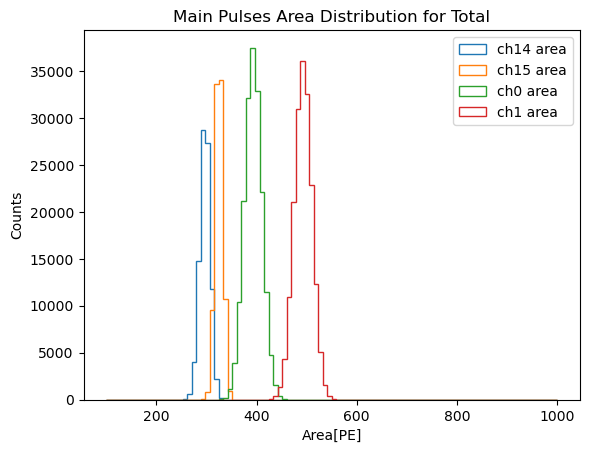

In [4]:
plt.hist(df_14.Area/8.79, bins=100, range=(1.E2,1.E3), histtype='step', label='ch14 area')
plt.hist(df_15.Area/9.19, bins=100, range=(1.E2,1E3), histtype='step', label='ch15 area')
plt.hist(df_0.Area/8.70, bins=100, range=(1.E2,1E3), histtype='step', label='ch0 area')
plt.hist(df_1.Area/9.19, bins=100, range=(1.E2,1E3), histtype='step', label='ch1 area')
plt.xlabel('Area[PE]')
plt.ylabel('Counts')
plt.title('Main Pulses Area Distribution for Total')
plt.legend()
plt.show()

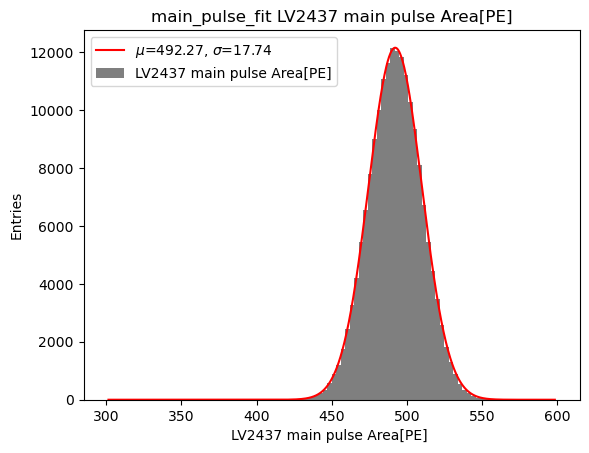

Fit: mu= 492.27, sigma =17.74


In [6]:
mu, sigma =ad.plot_fit_histgram_vs_Gaussion(df_1.Area/9.19, 100, 3.E2, 6.E2, [2E4, 5E2, 1.E1], file_tag='main_pulse_fit', xlabel='LV2437 main pulse Area[PE]', title='LV2437 main pulse Area[PE]')

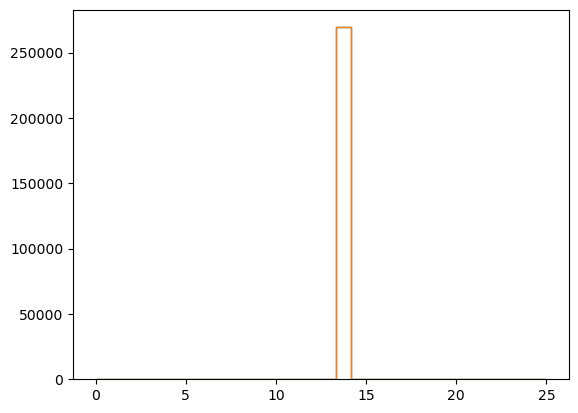

In [8]:
plt.hist(df_14.width, bins=30, range=(0,25), histtype='step')
plt.hist(df_15.width, bins=30, range=(0,25), histtype='step')
plt.show()

In [6]:
import numpy as np
from scipy.ndimage import uniform_filter1d

def pulse_index(waveform_data, baseline, threshold=0.01, max_search_length=7):
    # 平滑波形，减少噪声影响
    smoothed_waveform = uniform_filter1d(waveform_data, size=5)
    
    mind_index = np.argmin(smoothed_waveform)
    
    # 向左搜索回到基线
    start_index = mind_index
    count = 0
    while start_index > 0 and (smoothed_waveform[start_index] - baseline) < threshold and count < max_search_length:
        start_index -= 1
        count += 1
    
    # 向右搜索回到基线
    end_index = mind_index
    count = 0
    while end_index < len(smoothed_waveform) - 1 and (smoothed_waveform[end_index] - baseline) < threshold and count < max_search_length:
        end_index += 1
        count += 1
    
    return start_index, end_index, mind_index

In [10]:
df_14.loc[2].Wave, df_14.loc[2].Baseline

(array([8180, 8174, 8173, ..., 8178, 8175, 8182], dtype=int16), 8177)

In [13]:
df_sw = df_15[df_15.width > 10]
df_sw

,Ch,TTT,Baseline,Area,Hight,st,ed,md,width,WLen,Wave
1,15,1410376,8148,3043.945313,8148,111,125,118,14,1500,"[8145, 8149, 8146, 8145, 8147, 8144, 8145, 814..."
3,15,6410344,8147,2997.924805,8147,108,122,115,14,1500,"[8145, 8146, 8148, 8145, 8148, 8146, 8149, 814..."
5,15,11410308,8147,2956.848145,8147,109,123,116,14,1500,"[8153, 8151, 8146, 8146, 8148, 8148, 8151, 814..."
7,15,16410272,8146,2916.259766,8146,110,124,117,14,1500,"[8143, 8145, 8146, 8145, 8146, 8146, 8144, 815..."
9,15,21410236,8147,2938.537598,8147,112,126,119,14,1500,"[8149, 8149, 8148, 8151, 8149, 8148, 8153, 814..."
...,...,...,...,...,...,...,...,...,...,...,...
179393,15,448478301824,8148,2970.520020,8148,108,122,115,14,1500,"[8148, 8147, 8147, 8143, 8147, 8150, 8144, 814..."
179395,15,448483301788,8148,3048.034668,8148,110,124,117,14,1500,"[8149, 8149, 8143, 8148, 8148, 8149, 8151, 814..."
179397,15,448488301752,8149,2920.288086,8149,111,125,118,14,1500,"[8147, 8151, 8150, 8144, 8148, 8146, 8148, 814..."
179399,15,448493301720,8149,2966.186523,8149,109,123,116,14,1500,"[8151, 8153, 8150, 8147, 8148, 8151, 8154, 814..."


In [10]:
st,ed,md =pulse_index(df_sw.loc[1].Wave, df_sw.loc[1].Baseline,0.01, 7)     
st,ed,md, ed-st

(111, 125, 118, 14)

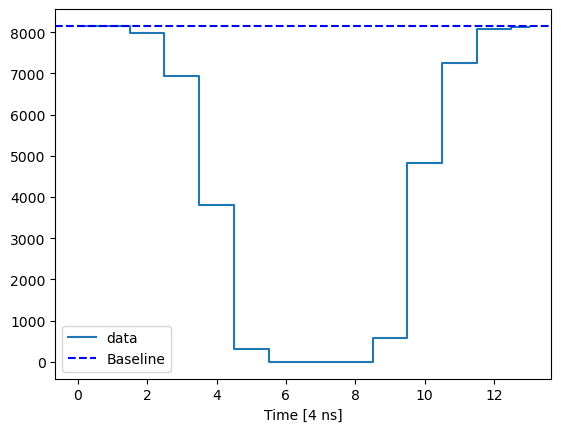

In [11]:
evt_index = 1
# evt_index = 
pt.plot_waveform_from_df(df_15, evt_index, 111, 125, title_str='')
# plt.ylim(6000,8500)

In [ ]:
plt.hist(df_14.st, bins=30, range=(75,140), histtype='step')
plt.hist(df_15.st, bins=30, range=(75,140), histtype='step')
plt.show()


In [ ]:
plt.hist(df_14.ed, bins=30, range=(75,140), histtype='step')
plt.hist(df_15.ed, bins=30, range=(75,140), histtype='step')
plt.show()

In [ ]:
plt.hist(df_14.md, bins=30, range=(75,140), histtype='step')
plt.hist(df_15.md, bins=30, range=(75,140), histtype='step')
plt.show()

## Scan and find out Main pulse and afterpulse 

In [11]:
def findpulse_st_ed(waveform_data: np.ndarray, baseline: int, referencePoint: int):
    """
    find the start, min, end index of pulse
    Args:
        waveform_data (np.ndarray): segment waveform data
        baseline (int): baseline of the segment
        referencePoint (int): reference point which over 20 adc in segment

    Returns:
        find the start, min, end index of referencePoint pulse, [-5, 15] window from referencePoint
    """
    
    start_range = max(0, referencePoint - 5)
    end_range = min(len(waveform_data), referencePoint + 5)

    min_index = referencePoint
    min_value = waveform_data[referencePoint]
    for i in range(start_range, end_range):
        if waveform_data[i] < min_value:
            min_value = waveform_data[i]
            min_index = i

    start_index = min_index
    while start_index > start_range:
        if (waveform_data[start_index] - waveform_data[start_index - 1]) < 0:
            start_index -= 1
        else:
            break

    end_index = min_index
    if end_index + 1 < end_range and waveform_data[min_index] == waveform_data[end_index + 1]:
        end_index += 1

    while end_index + 1 < end_range:
        if (waveform_data[end_index + 1] - waveform_data[end_index]) > 0:
            end_index += 1
        else:
            break

    return start_index, min_index, end_index

In [12]:
'''
def find_pulse_edges(waveform, referencePoint, baseline, base_threshold=0.05):
    """
    waveform: 波形数组
    referencePoint: 脉冲参考点（大致脉冲中心）
    base_window: 用于基线估计的窗口大小（参考点前后）
    base_threshold: 判断回到基线的阈值
    
    返回：起始点索引，终止点索引
    """
    n = len(waveform)
    
        
    # 2. 动态确定搜索窗口（例如参考点±50，避免越界）
    search_start = max(0, referencePoint - 20)
    search_end = min(n, referencePoint + 20)
    search_window = waveform[search_start:search_end]
    
    # 3. 找最小点（脉冲中心）
    min_rel_idx = np.argmin(search_window)
    min_index = search_start + min_rel_idx
    
    # 4. 向左寻找起始点：第一个回到基线附近的点
    start_index = min_index
    for i in range(min_index, search_start - 1, -1):
        if abs(waveform[i] - baseline) <= base_threshold:
            start_index = i
            break
    
    # 5. 向右寻找终止点：第一个回到基线附近的点
    end_index = min_index
    for i in range(min_index, search_end):
        if abs(waveform[i] - baseline) <= base_threshold:
            end_index = i
            break
    
    return start_index, min_index, end_index
'''

In [12]:
import logging
def filter_points(points, min_interval):
    filtered = []
    last_idx = None
    for idx in points:
        if last_idx is None or idx - last_idx >= min_interval:
            filtered.append(idx)
            last_idx = idx
    return filtered

def filter_after_pulses(df_after_pulse, min_interval=3):
    """
    过滤 after_pulse DataFrame 中 start 时间点间隔小于 min_interval 的行。
    如果两个 start 时间点间隔小于 min_interval，则滤除后一个时间点对应的行。
    
    参数:
        df_after_pulse: pandas.DataFrame，必须包含 'start' 列，且为数值类型。
        min_interval: int，最小间隔阈值，单位为样本数。
    
    返回:
        过滤后的 DataFrame。
    """
    # 先按 start 排序，确保顺序正确
    df_sorted = df_after_pulse.sort_values('min_point').reset_index(drop=True)
    
    # 用一个布尔列表标记哪些行保留，初始都保留
    keep = [True] * len(df_sorted)
    
    for i in range(1, len(df_sorted)):
        # 计算当前start与前一个start的差值
        diff = df_sorted.loc[i, 'min_point'] - df_sorted.loc[i-1, 'min_point']
        if diff < min_interval:
            # 间隔小于阈值，滤除当前行（i）
            keep[i] = False
    
    # 返回过滤后的 DataFrame
    return df_sorted[keep].reset_index(drop=True)

def filter_all_segments(df_after_pulse, min_interval=3):
    filtered_segments = []
    for segment_id, group_df in df_after_pulse.groupby('segment'):
        filtered_df = filter_after_pulses(group_df, min_interval)
        filtered_segments.append(filtered_df)
    # 合并所有过滤后的segment
    result_df = pd.concat(filtered_segments, ignore_index=True)
    return result_df

def cal_area(waveform_data, st: int, ed: int, baseline: int):
    sum_val = np.sum(waveform_data[st: ed])
    area = baseline * (ed - st) - sum_val
    pe_fact = (2./16384)*4.e-9/(50*1.6e-19)/1.e6  # 转换系数
    return area * pe_fact

In [13]:
import numpy as np
import pandas as pd

def afterpulse_scan_from_df(
    df_main: pd.DataFrame,    
    threshold: int = 20,
    afterpulse_min_interval: int = 35,
):
    """
    输入:
        df_main: 包含主脉冲信息的DataFrame，必须包含Ch, TTT, Baseline, st, ed, md, Hight, Area, Wave等列
        waveforms_dict: dict，key为TTT，value为对应波形np.ndarray
        threshold: 触发阈值
        main_pulse_height_threshold: 主脉冲高度阈值（用于判断主脉冲，后脉冲不判断）
        afterpulse_min_interval: 后脉冲起始点距离主脉冲结束点的最小间隔
    
    返回:
        pd.DataFrame，包含主脉冲和后脉冲信息
    """

    all_pulses = []

    for idx, row in df_main.iterrows():
        Ch = row['Ch']
        TTT = row['TTT']
        baseline = row['Baseline']
        st_main = row['st']
        ed_main = row['ed']
        minp_main = row['md']
        height_main = row['Hight']
        area_main = row['Area']
        waveform = row['Wave']

        # 先保存主脉冲信息
        main_pulse_info = {
            'Ch': Ch,
            'TTT': TTT,
            'segment': idx,
            'pulse_index': 0,
            'baseline': baseline,
            'start': st_main,
            'end': ed_main,
            'width': ed_main - st_main,
            'height': height_main,
            'min_point': minp_main,
            'area': area_main,
            'is_main_pulse': True,
            'time_interval_start': 0,
            'time_interval_min_point': 0,
        }
        all_pulses.append(main_pulse_info)

        # 获取对应波形
        # waveform = waveforms_dict.get(TTT, None)
        if waveform is None:
            print(f"Warning: TTT {TTT} waveform not found, skip afterpulse search")
            continue

        n = len(waveform)
        search_start = st_main + afterpulse_min_interval
        if search_start >= n:
            # 没有足够数据寻找后脉冲
            continue

        # 寻找后脉冲参考点：波形低于baseline - threshold的点
        ref_points = []
        above_threshold = False
        for i in range(search_start, n):
            if baseline - waveform[i] > threshold:
                if not above_threshold:
                    ref_points.append(i)
                    above_threshold = True
            else:
                above_threshold = False

        # 过滤相邻参考点，避免重复计数
        ref_points = filter_points(ref_points, 2)
        # ReferencePoints = filter_points(ReferencePoints, 2)

        pulse_idx_in_event = 1  # 后脉冲索引从1开始

        for ref_idx in ref_points:
            try:
                st, minp, ed = findpulse_st_ed(waveform, baseline, ref_idx)
            except Exception as e:
                # print(f"findpulse_st_ed error at TTT {TTT}, ref_idx {ref_idx}: {e}")
                continue

            if ed < st:
                continue

            pulse_height = baseline - waveform[minp]
            if pulse_height < threshold:
                continue

            area = cal_area(waveform, st, ed, baseline)

            time_interval_start = st - st_main
            time_interval_min_point = minp - minp_main

            after_pulse_info = {
                'Ch': Ch,                
                'TTT': TTT,
                'segment': idx,                
                'pulse_index': pulse_idx_in_event,
                'baseline': baseline,
                'start': st,
                'end': ed,
                'width': ed - st,
                'height': pulse_height,
                'min_point': minp,
                'area': area,
                'is_main_pulse': False,
                'time_interval_start': time_interval_start,
                'time_interval_min_point': time_interval_min_point,
            }
            all_pulses.append(after_pulse_info)
            pulse_idx_in_event += 1

    df_all = pd.DataFrame(all_pulses)
    return df_all

In [7]:
df0 = df_15.iloc[:10]
# df0.Baseline, df0.start, df0.
# df0.Wave

In [14]:
df_15_afterpulse_1 = prc.afterpulse_scan_from_df(df0)

In [15]:
df_15_afterpulse_1

,Ch,TTT,segment,pulse_index,baseline,start,end,width,height,min_point,area,is_main_pulse,time_interval_start,time_interval_min_point
0,15,1410376,0,0,8148,111,125,14,8148,118,3043.945313,True,0,0
1,15,1410376,0,1,8148,152,158,6,133,154,7.263184,False,41,36
2,15,1410376,0,2,8148,179,184,5,55,180,4.943848,False,68,62
3,15,1410376,0,3,8148,187,192,5,77,190,8.728027,False,76,72
4,15,1410376,0,4,8148,198,203,5,262,199,21.240234,False,87,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,15,46410064,9,11,8148,323,327,4,371,325,50.354004,False,214,209
95,15,46410064,9,12,8148,388,393,5,57,390,8.056641,False,279,274
96,15,46410064,9,13,8148,433,440,7,83,436,6.958008,False,324,320
97,15,46410064,9,14,8148,607,611,4,49,609,3.417969,False,498,493


In [11]:
df_14_after_pulse = prc.afterpulse_scan_from_df(df_14)
df_15_after_pulse = prc.afterpulse_scan_from_df(df_15)

In [13]:
df_app_all =pd.concat([df_14_after_pulse, df_15_after_pulse], ignore_index=True)
filename = '/mnt/data/outnpy/afterpulse_LV2204_LV2437_scan.h5py'
prc.write_to_hdf5(df_app_all, filename)


h5 Write Time: 1.64 s 
h5 File Size: 109.39 MB
Save to /mnt/data/outnpy/afterpulse_LV2204_LV2437_scan.h5py


(1.636857271194458, 114707322)

In [12]:
df_15_after_pulse.head(10)

,Ch,TTT,segment,pulse_index,baseline,start,end,width,height,min_point,area,is_main_pulse,time_interval_start,time_interval_min_point
0,15,1410376,0,0,8148,111,125,14,8148,118,3043.945313,True,0,0
1,15,1410376,0,1,8148,152,158,6,133,154,7.263184,False,41,36
2,15,1410376,0,2,8148,179,184,5,55,180,4.943848,False,68,62
3,15,1410376,0,3,8148,187,192,5,77,190,8.728027,False,76,72
4,15,1410376,0,4,8148,198,203,5,262,199,21.240234,False,87,81
5,15,1410376,0,5,8148,256,261,5,52,258,4.272461,False,145,140
6,15,1410376,0,6,8148,306,313,7,37,309,3.051758,False,195,191
7,15,1410376,0,7,8148,365,368,3,29,366,2.136230,False,254,248
8,15,1410376,0,8,8148,373,378,5,42,375,3.845215,False,262,257
9,15,1410376,0,9,8148,382,385,3,277,384,16.906738,False,271,266


## filter repeated afterpulse counts in one segment 

In [16]:
df_15_afterpulse_1_filtered = prc.filter_after_pulses(df_15_afterpulse_1[df_15_afterpulse_1.segment == 3], min_interval=3)
df_15_afterpulse_1_filtered[:30]

,Ch,TTT,segment,pulse_index,baseline,start,end,width,height,min_point,area,is_main_pulse,time_interval_start,time_interval_min_point
0,15,16410272,3,0,8146,110,124,14,8146,117,2916.259766,True,0,0
1,15,16410272,3,1,8146,142,149,7,27,144,-18.493652,False,32,27
2,15,16410272,3,2,8146,185,190,5,43,187,5.249023,False,75,70
3,15,16410272,3,3,8146,208,211,3,192,209,17.517090,False,98,92
4,15,16410272,3,4,8146,230,234,4,63,232,4.516602,False,120,115
5,15,16410272,3,5,8146,237,241,4,41,239,2.990723,False,127,122
6,15,16410272,3,6,8146,268,271,3,55,269,4.089355,False,158,152
7,15,16410272,3,7,8146,294,299,5,792,295,74.707031,False,184,178
8,15,16410272,3,8,8146,307,311,4,37,309,3.417969,False,197,192
9,15,16410272,3,9,8146,348,353,5,72,350,6.286621,False,238,233


In [125]:
# filtered_df_15 = prc.filter_after_pulses(df_15_after_pulse[df_15_after_pulse.segment == 0], min_interval=10)
# filtered_df_15[:100]

## filter all repeated afterpulse in data

In [39]:
all_filtered_app_14 = prc.filter_all_segments(df_14_after_pulse)
all_filtered_app_15 = prc.filter_all_segments(df_15_after_pulse)

## example waveforms of found

In [86]:
all_filtered_app_14[all_filtered_app_14.Ch == 14]

,Ch,TTT,segment,pulse_index,baseline,start,end,width,height,min_point,area,is_main_pulse,time_interval_start,time_interval_min_point
0,14,1410376,0,0,8178,111,125,14,8178,118,2705.627441,True,0,0
1,14,1410376,0,1,8178,161,165,4,119,163,9.216309,False,50,45
2,14,1410376,0,2,8178,173,179,6,44,175,4.028320,False,62,57
3,14,1410376,0,3,8178,184,191,7,599,188,58.898926,False,73,70
4,14,1410376,0,4,8178,206,211,5,88,208,6.225586,False,95,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604288,14,448498301684,89700,4,8177,306,311,5,46,309,4.760742,False,196,192
604289,14,448498301684,89700,5,8177,367,372,5,43,368,5.249023,False,257,251
604290,14,448498301684,89700,6,8177,419,425,6,74,421,6.530762,False,309,304
604291,14,448498301684,89700,7,8177,437,441,4,38,438,3.173828,False,327,321


In [87]:
all_filtered_app_15[all_filtered_app_15.Ch == 15]

,Ch,TTT,segment,pulse_index,baseline,start,end,width,height,min_point,area,is_main_pulse,time_interval_start,time_interval_min_point
0,15,1410376,0,0,8148,111,125,14,8148,118,3043.945313,True,0,0
1,15,1410376,0,1,8148,152,158,6,133,154,7.263184,False,41,36
2,15,1410376,0,2,8148,179,184,5,55,180,4.943848,False,68,62
3,15,1410376,0,3,8148,187,192,5,77,190,8.728027,False,76,72
4,15,1410376,0,5,8148,256,261,5,52,258,4.272461,False,145,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848372,15,448498301684,89700,5,8148,205,210,5,379,207,37.170410,False,95,90
848373,15,448498301684,89700,6,8148,240,243,3,104,242,9.338379,False,130,125
848374,15,448498301684,89700,8,8148,269,275,6,45,271,2.502441,False,159,154
848375,15,448498301684,89700,9,8148,292,298,6,112,294,8.850098,False,182,177


In [17]:
df_15_afterpulse_1[:30]

,Ch,TTT,segment,pulse_index,baseline,start,end,width,height,min_point,area,is_main_pulse,time_interval_start,time_interval_min_point
0,15,1410376,0,0,8148,111,125,14,8148,118,3043.945313,True,0,0
1,15,1410376,0,1,8148,152,158,6,133,154,7.263184,False,41,36
2,15,1410376,0,2,8148,179,184,5,55,180,4.943848,False,68,62
3,15,1410376,0,3,8148,187,192,5,77,190,8.728027,False,76,72
4,15,1410376,0,4,8148,198,203,5,262,199,21.240234,False,87,81
5,15,1410376,0,5,8148,256,261,5,52,258,4.272461,False,145,140
6,15,1410376,0,6,8148,306,313,7,37,309,3.051758,False,195,191
7,15,1410376,0,7,8148,365,368,3,29,366,2.136230,False,254,248
8,15,1410376,0,8,8148,373,378,5,42,375,3.845215,False,262,257
9,15,1410376,0,9,8148,382,385,3,277,384,16.906738,False,271,266


In [21]:
segment = 0
index = 0
df_15_afterpulse_1_filtered = prc.filter_after_pulses(df_15_afterpulse_1[df_15_afterpulse_1.segment == segment], min_interval=3)
minp = df_15_afterpulse_1_filtered[df_15_afterpulse_1_filtered.segment == segment].min_point
idex = df_15_afterpulse_1_filtered[df_15_afterpulse_1_filtered.segment == segment].pulse_index
area = df_15_afterpulse_1_filtered[df_15_afterpulse_1_filtered.segment == segment].area/9.19
start = df_15_afterpulse_1_filtered[df_15_afterpulse_1_filtered.segment == segment].start
end = df_15_afterpulse_1_filtered[df_15_afterpulse_1_filtered.segment == segment].end

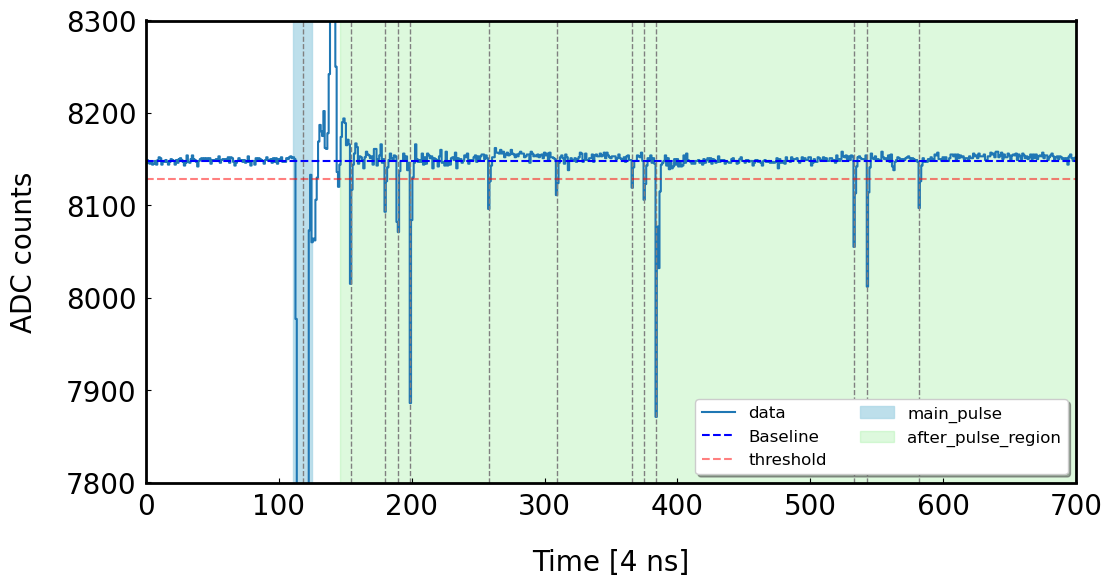

In [38]:
waveform = df_15.iloc[index].Wave
baseline = df_15.iloc[index].Baseline
x = np.arange(len(waveform))
plt.figure(figsize=(12, 6))
plt.step(x, waveform, where='mid', label='data')
plt.axhline(y=baseline, color='b', linestyle='--', label='Baseline')  
i =0
for m in minp:
    plt.axvline(x=m, color='grey', linestyle='--', linewidth=1, label='')  
    # plt.text(m, 8250, f'area:{area[i]:.2f}', fontsize=12, color='black', ha='center', va='center', rotation=75)
    # plt.axvline(x=start[i], color='b', linestyle='--', linewidth=1, label='')  
    # plt.axvline(x=end[i], color='black', linestyle='--', linewidth=1, label='')  
    i += 1

# plt.axvline(x=df_15.iloc[index].st, color='b', linestyle='--', label='main_start')  
# plt.axvline(x=df_15.iloc[index].st + 35, color='g', linestyle='--', label='app_start_search')

plt.axhline(y=baseline - 20, color='r', alpha=0.5, linestyle='--',  label='threshold')  

mst, med =df_15.iloc[index].st, df_15.iloc[index].ed
ast = df_15.iloc[index].st + 35
plt.axvspan(mst, med, color='lightblue', alpha=0.8, label='main_pulse')
plt.axvspan(ast,ast + 700, color='lightgreen', alpha=0.3, label='after_pulse_region')

plt.legend(loc='lower right',fontsize=12,shadow=True, fancybox=True, ncol=2)
plt.xlabel('Time [4 ns]',labelpad=20, fontsize=20)
plt.ylabel("ADC counts", labelpad=20, fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(which='both', direction='in', labelsize=20, pad=7)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)  
plt.xlim(0,700)
plt.ylim(7800, 8300)
plt.savefig(f'figs/ch15_segment{index}_afterpulses_wf.png', dpi=300, bbox_inches='tight')
plt.show()

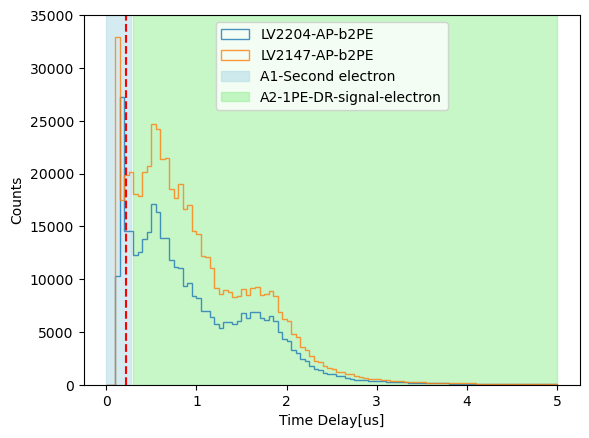

In [95]:
from matplotlib import cm
cmp = plt.cm.rainbow(np.linspace(0, 1, 7))

plt.hist(a2pe_ch14.time_interval_min_point[a2pe_ch14.Ch ==14]*4/1000, bins=100, range=(0, 5), histtype='step',linewidth=1, alpha=0.8, label='LV2204-AP-b2PE')
plt.hist(a2pe_ch15.time_interval_min_point[a2pe_ch15.Ch == 15]*4/1000, bins=100, range=(0, 5), histtype='step',linewidth=1, alpha=0.8, label='LV2147-AP-b2PE')
plt.axvspan(0.00, 0.28, color='lightblue', alpha=0.5, label='A1-Second electron')
plt.axvspan(0.3, 5, color='lightgreen', alpha=0.5, label='A2-1PE-DR-signal-electron')
# plt.text(0.00, 0.28, 'Second electron scatter', fontsize=24, color='lightblue', ha='center', va='center', bbox=dict(facecolor='NONE', edgecolor='lightblue', alpha=1))
# plt.axvline(x=0.7, linestyle='--', color='red')
plt.axvline(x=0.22, linestyle='--', color='red')

plt.ylim(0,3.5E4)
plt.legend()
plt.xlabel('Time Delay[us]')
plt.ylabel('Counts')
plt.savefig('figs/afterpulse_second_electron_scatter_total.png', bbox_inches='tight')
plt.show()

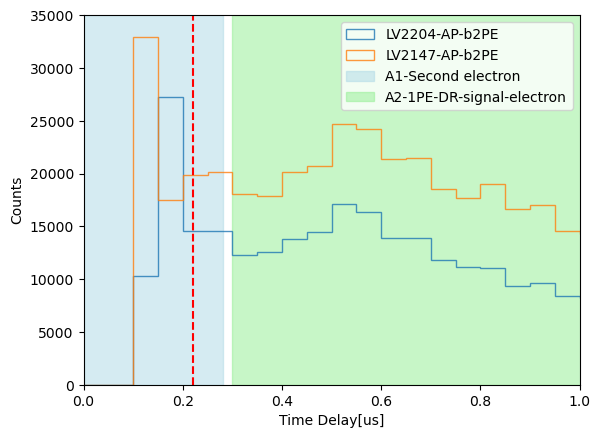

In [97]:
from matplotlib import cm
cmp = plt.cm.rainbow(np.linspace(0, 1, 7))

plt.hist(a2pe_ch14.time_interval_min_point[a2pe_ch14.Ch ==14]*4/1000, bins=100, range=(0, 5), histtype='step',linewidth=1, alpha=0.8, label='LV2204-AP-b2PE')
plt.hist(a2pe_ch15.time_interval_min_point[a2pe_ch15.Ch == 15]*4/1000, bins=100, range=(0, 5), histtype='step',linewidth=1, alpha=0.8, label='LV2147-AP-b2PE')
plt.axvspan(0.00, 0.28, color='lightblue', alpha=0.5, label='A1-Second electron')
plt.axvspan(0.3, 5, color='lightgreen', alpha=0.5, label='A2-1PE-DR-signal-electron')

# plt.text(0.00, 0.28, 'Second electron scatter', fontsize=24, color='lightblue', ha='center', va='center', bbox=dict(facecolor='NONE', edgecolor='lightblue', alpha=1))
plt.axvline(x=0.22, linestyle='--', color='red')
plt.ylim(0,3.5E4)
plt.xlim(0,1)
plt.legend()
plt.xlabel('Time Delay[us]')
plt.ylabel('Counts')
plt.savefig('figs/afterpulse_second_electron_scatter_zoomin_total.png', bbox_inches='tight')
plt.show()

In [71]:
all_filtered_app_15.head(2)

,Ch,TTT,segment,pulse_index,baseline,start,end,width,height,min_point,area,is_main_pulse,time_interval_start,time_interval_min_point
0,15,1410376,0,0,8148,111,125,14,8148,118,3043.945313,True,0,0
1,15,1410376,0,1,8148,152,158,6,133,154,7.263184,False,41,36


In [53]:
# al2pe_ch15 = all_filtered_app_15[(all_filtered_app_15['area'] >= 2) & (all_filtered_app_15['time_interval_min_point'] >= 0.22)]
# al2pe_ch14 = all_filtered_app_14[(all_filtered_app_14['area'] >= 2) & (all_filtered_app_14['time_interval_min_point'] >= 0.22)]

al2pe_ch15 = all_filtered_app_15[(all_filtered_app_15['area']/8.94 >= 2)]
al2pe_ch14 = all_filtered_app_14[(all_filtered_app_14['area']/9.19 >= 2)]
a2pe_ch15 = all_filtered_app_15[(all_filtered_app_15['area']/8.94 < 2)]
a2pe_ch14 = all_filtered_app_14[(all_filtered_app_14['area']/9.19 < 2)]

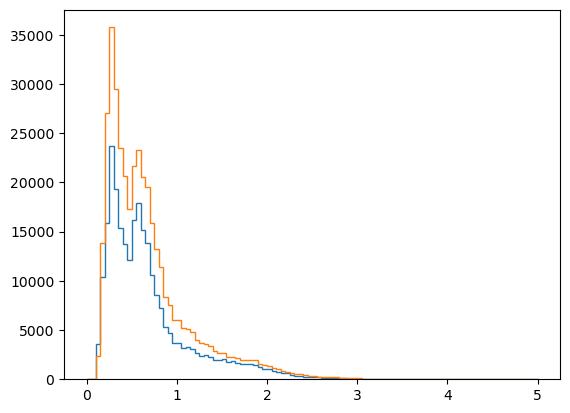

In [42]:
# al2pe_ch15[(al2pe_ch15.pulse_index != 0) & (al2pe_ch15.time_interval_min_point < 0.3)] 
plt.hist(al2pe_ch14.time_interval_min_point[(al2pe_ch14.pulse_index != 0)]*4/1000, bins=100, range=(0, 5), histtype='step', label='ch14')
plt.hist(al2pe_ch15.time_interval_min_point[(al2pe_ch15.pulse_index != 0)]*4/1000, bins=100, range=(0, 5), histtype='step', label='ch15')
plt.show()

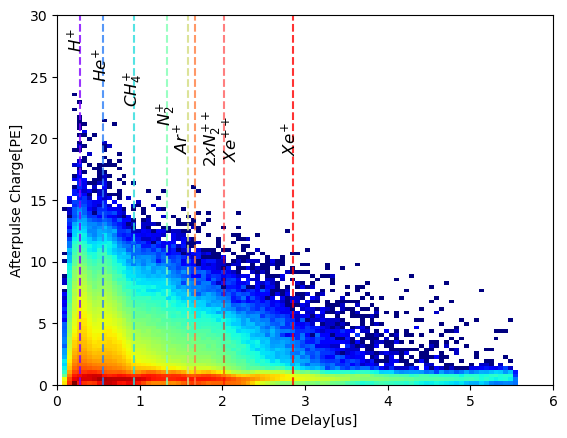

In [162]:
import matplotlib.colors
# plt.figure(figsize=(8, 6))
plt.hist2d(all_filtered_app_15.time_interval_min_point[all_filtered_app_15.pulse_index != 0]*4/1000, 
       all_filtered_app_15.area[all_filtered_app_15.pulse_index != 0]/9.19, 
       bins=[100, 100],
       range=[[0, 6], [0, 30]],  # 限制绘图范围
       cmap='jet',
       density=True,
       norm=matplotlib.colors.LogNorm()
    )
plt.axvline(x=0.28, color=cmp[0],alpha=0.8, linestyle='--',  linewidth=1.5  ,label='$H^{+}$')
plt.text(0.22, 28, '$H^{+}$', fontsize=12, color='black', ha='center', va='center', rotation=90)

plt.axvline(x=0.56, color=cmp[1],alpha=0.8, linestyle='--',  linewidth=1.5  ,label='$He^{+}$')
plt.text(0.52, 26, '$He^{+}$', fontsize=12, color='black', ha='center', va='center', rotation=90)

plt.axvline(x=0.93, color=cmp[2],alpha=0.8, linestyle='--',  linewidth=1.5  ,label='$CH_{4}^{+}$')
plt.text(0.92, 24, '$CH_{4}^{+}$', fontsize=12, color='black', ha='center', va='center', rotation=90)

plt.axvline(x=1.33, color=cmp[3],alpha=0.8, linestyle='--',  linewidth=1.5  ,label='$N_{2}^{+}$')
plt.text(1.32, 22, '$N_{2}^{+}$', fontsize=12, color='black', ha='center', va='center', rotation=90)

plt.axvline(x=1.58, color=cmp[4],alpha=0.8, linestyle='--',  linewidth=1.5  ,label='$Ar^{+}$')
plt.text(1.5, 20, '$Ar^{+}$', fontsize=12, color='black', ha='center', va='center', rotation=90)

plt.axvline(x=1.67, color=cmp[5],alpha=0.8, linestyle='--',  linewidth=1.5  ,label='2$x N_{2}^{++}$')
plt.text(1.88, 20, '2$x N_{2}^{++}$', fontsize=12, color='black', ha='center', va='center', rotation=90)

plt.axvline(x=2.02, color=cmp[6],alpha=0.5, linestyle='--',  linewidth=1.5  ,label='$Xe^{+}$')
plt.text(2.1, 20, '$Xe^{++}$', fontsize=12, color='black', ha='center', va='center', rotation=90)
plt.axvline(x=2.85, color=cmp[6],alpha=0.8, linestyle='--',  linewidth=1.5  ,label='$Xe^{+}$')
plt.text(2.81, 20, '$Xe^{+}$', fontsize=12, color='black', ha='center', va='center', rotation=90)

# plt.axvline(x=0.22, linestyle='--', color='red')
# plt.colorbar(label='Counts')  # 添加颜色条
plt.xlabel('Time Delay[us]')
plt.ylabel('Afterpulse Charge[PE]')
plt.show()

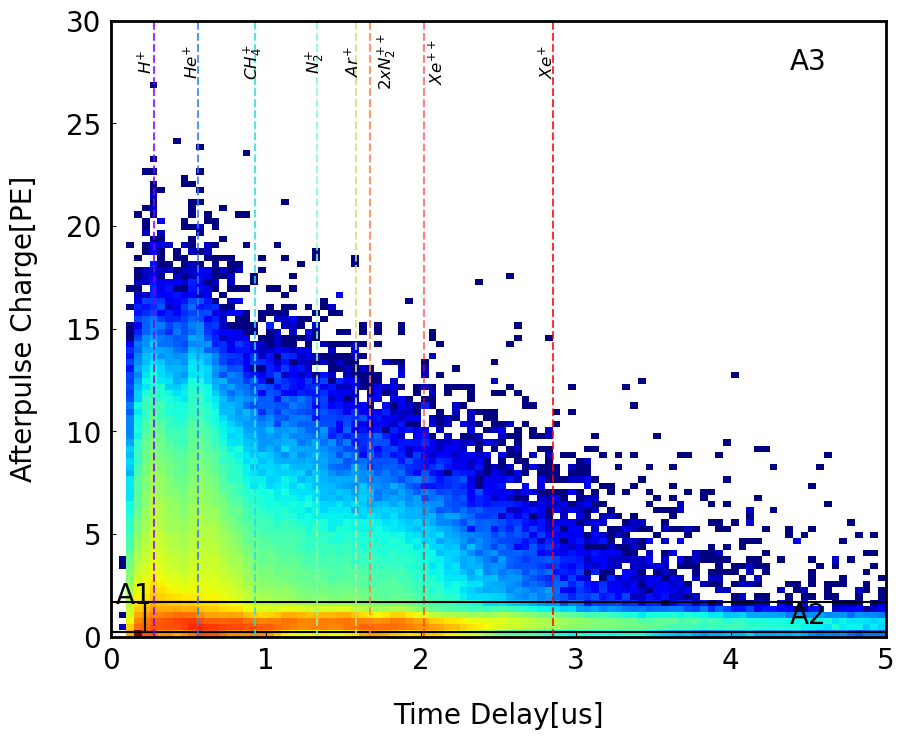

In [179]:
import matplotlib.colors
from matplotlib.patches import Rectangle
plt.figure(figsize=(10, 8))
plt.hist2d(all_filtered_app_14.time_interval_min_point[all_filtered_app_14.pulse_index != 0]*4/1000, 
       all_filtered_app_14.area[all_filtered_app_14.pulse_index != 0]/8.39, 
       bins=[100, 100],
       range=[[0, 5], [0, 30]],  # 限制绘图范围
       cmap='jet',  #'jet', 'rainbow'
       density=True,
       norm=matplotlib.colors.LogNorm()
    )
plt.axvline(x=0.28, color=cmp[0],alpha=0.8, linestyle='--',  linewidth=1.5  ,label='$H^{+}$')
plt.text(0.22, 28, '$H^{+}$', fontsize=12, color='black', ha='center', va='center', rotation=90)

plt.axvline(x=0.56, color=cmp[1],alpha=0.8, linestyle='--',  linewidth=1.5  ,label='$He^{+}$')
plt.text(0.52, 28, '$He^{+}$', fontsize=12, color='black', ha='center', va='center', rotation=90)

plt.axvline(x=0.93, color=cmp[2],alpha=0.8, linestyle='--',  linewidth=1.5  ,label='$CH_{4}^{+}$')
plt.text(0.92, 28, '$CH_{4}^{+}$', fontsize=12, color='black', ha='center', va='center', rotation=90)

plt.axvline(x=1.33, color=cmp[3],alpha=0.8, linestyle='--',  linewidth=1.5  ,label='$N_{2}^{+}$')
plt.text(1.32, 28, '$N_{2}^{+}$', fontsize=12, color='black', ha='center', va='center', rotation=90)

plt.axvline(x=1.58, color=cmp[4],alpha=0.8, linestyle='--',  linewidth=1.5  ,label='$Ar^{+}$')
plt.text(1.56, 28, '$Ar^{+}$', fontsize=12, color='black', ha='center', va='center', rotation=90)

plt.axvline(x=1.67, color=cmp[5],alpha=0.8, linestyle='--',  linewidth=1.5  ,label='2$x N_{2}^{++}$')
plt.text(1.78, 28, '2$x N_{2}^{++}$', fontsize=12, color='black', ha='center', va='center', rotation=90)

plt.axvline(x=2.02, color=cmp[6],alpha=0.5, linestyle='--',  linewidth=1.5  ,label='$Xe^{+}$')
plt.text(2.1, 28, '$Xe^{++}$', fontsize=12, color='black', ha='center', va='center', rotation=90)
plt.axvline(x=2.85, color=cmp[6],alpha=0.8, linestyle='--',  linewidth=1.5  ,label='$Xe^{+}$')
plt.text(2.81, 28, '$Xe^{+}$', fontsize=12, color='black', ha='center', va='center', rotation=90)

rect1 = Rectangle(
    (0., 0.2),     # 左下角坐标 (x, y)
    0.22,            # 宽度
    1.5,            # 高度
    linewidth=1.5,    # 边框线宽
    edgecolor='black',# 边框颜色
    facecolor='none' # 填充颜色为透明
)
rect2 = Rectangle(
    (0.22, 0.2),     # 左下角坐标 (x, y)
    5.5,            # 宽度
    1.5,            # 高度
    linewidth=1.5,    # 边框线宽
    edgecolor='black',# 边框颜色
    facecolor='none' # 填充颜色为透明
)
plt.gca().add_patch(rect1,)
plt.gca().add_patch(rect2,)
plt.text(0.15,2., 'A1', fontsize=20, color='black', ha='center', va='center')
plt.text(4.5,1., 'A2', fontsize=20, color='black', ha='center', va='center')
plt.text(4.5,28., 'A3', fontsize=20, color='black', ha='center', va='center')
# plt.legend(loc='lower right',fontsize=12,shadow=True, fancybox=True, ncol=2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(which='both', direction='in', labelsize=20, pad=7)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)  

# plt.axvline(x=0.22, linestyle='--', color='red')
# plt.colorbar(label='Counts')  # 添加颜色条
plt.xlabel('Time Delay[us]',labelpad=20, fontsize=20)
plt.ylabel('Afterpulse Charge[PE]',labelpad=20, fontsize=20)
plt.savefig('figs/app_area_dt.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
al2pe_ch14[al2pe_ch14.Ch == 0]

In [ ]:
from matplotlib import cm
cmp = plt.cm.rainbow(np.linspace(0, 1, 7))

# plt.hist(al2pe_ch14.time_interval_min_point[(al2pe_ch14.pulse_index != 0) ]*4/1000, bins=100, range=(0, 5), histtype='step',linewidth=1, alpha=0.8, label='LV2204-AP')
plt.hist(al2pe_ch15.time_interval_min_point[(al2pe_ch15.pulse_index != 0) ]*4/1000, bins=100, range=(0, 6), histtype='step',
        # edgecolor='black',
        # facecolor='blue', 
        # hatch='/\\' ,
        linewidth=1.5, alpha=0.8, label='')

'''
plt.axvline(x=0.28, color=cmp[0],alpha=0.8, linestyle='--',  linewidth=1.5  ,label='$H^{+}$')
plt.text(0.22, 5.6E4, '$H^{+}$', fontsize=12, color='black', ha='center', va='center', rotation=90)

plt.axvline(x=0.56, color=cmp[1],alpha=0.8, linestyle='--',  linewidth=1.5  ,label='$He^{+}$')
plt.text(0.52, 5.6E4, '$He^{+}$', fontsize=12, color='black', ha='center', va='center', rotation=90)

plt.axvline(x=0.93, color=cmp[2],alpha=0.8, linestyle='--',  linewidth=1.5  ,label='$CH_{4}^{+}$')
plt.text(0.92, 5.6E4, '$CH_{4}^{+}$', fontsize=12, color='black', ha='center', va='center', rotation=90)

plt.axvline(x=1.33, color=cmp[3],alpha=0.8, linestyle='--',  linewidth=1.5  ,label='$N_{2}^{+}$')
plt.text(1.32, 5.4E4, '$N_{2}^{+}$', fontsize=12, color='black', ha='center', va='center', rotation=90)

plt.axvline(x=1.58, color=cmp[4],alpha=0.8, linestyle='--',  linewidth=1.5  ,label='$Ar^{+}$')
plt.text(1.5, 5.2E4, '$Ar^{+}$', fontsize=12, color='black', ha='center', va='center', rotation=90)

plt.axvline(x=1.67, color=cmp[5],alpha=0.8, linestyle='--',  linewidth=1.5  ,label='2$x N_{2}^{++}$')
plt.text(1.88, 5.1E4, '2$x N_{2}^{++}$', fontsize=12, color='black', ha='center', va='center', rotation=90)

plt.axvline(x=2.02, color=cmp[6],alpha=0.8, linestyle='--',  linewidth=1.5  ,label='$Xe^{+}$')
plt.text(2.1, 5.E4, '$Xe^{++}$', fontsize=12, color='black', ha='center', va='center', rotation=90)

plt.axvline(x=2.85, color=cmp[6],alpha=0.8, linestyle='--',  linewidth=1.5  ,label='$Xe^{+}$')
plt.text(2.81, 5.E4, '$Xe^{+}$', fontsize=12, color='black', ha='center', va='center', rotation=90)
'''
# plt.axvspan(0.20, 5, color='lightblue', alpha=0.5, label='A3 APP')
# plt.text(0.00, 0.28, 'Second electron scatter', fontsize=24, color='lightblue', ha='center', va='center', bbox=dict(facecolor='NONE', edgecolor='lightblue', alpha=1))
# plt.axvline(x=0.7, linestyle='--', color='red')
# plt.ylim(0,6E4)
# plt.xlim(0,1)
plt.xlabel('Time Delay[us]',labelpad=20, fontsize=20)
plt.ylabel('Counts',labelpad=20, fontsize=20)

# plt.legend()
# plt.legend(loc='upper right',shadow=True, fancybox=True, ncol=2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(which='both', direction='in', labelsize=20, pad=7)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)  

# plt.yscale('log')
# plt.savefig('figs/app_df.pdf', bbox_inches='tight')
plt.show()

In [90]:

# def cal_app_charge_ratio(df_after_pulse):
#     """
#     遍历所有 segment，计算每个 segment 的 after pulse 概率 (app)，
#     返回一个列表，列表元素为字典，格式：{'segment': segment_id, 'app': app_value}
#     """
#     app_list = []
#     segments = df_after_pulse['segment'].unique()
#     total_main_pulses = []
#     afterpulse_total = []
#     for seg in segments:
#         df_seg = df_after_pulse[df_after_pulse['segment'] == seg]
#         after_pulses = df_seg.area[df_seg['pulse_index'] != 0].sum()
#         main_pulses = df_seg.area[df_seg['pulse_index'] == 0].values.sum()
#         afterpulse_total.append(after_pulses)
#         total_main_pulses.append(main_pulses)
#     app = sum(afterpulse_total) / sum(total_main_pulses)
#     print(app)
#     return app

## all afterpulse area largeer than 2 PE

In [54]:
al2pe_ch14.area[al2pe_ch14.pulse_index != 0].sum(), al2pe_ch15.area[al2pe_ch15.pulse_index != 0].sum()

(11255822.875976564, 15265485.839843752)

## afterpulse probabilisty

In [55]:
(a2pe_ch15.area[a2pe_ch15.time_interval_min_point > 55].sum()  + al2pe_ch15.area[al2pe_ch15.pulse_index != 0].sum()  ) /all_filtered_app_15.area.sum()

0.023118722789496605

In [56]:
( a2pe_ch14.area[a2pe_ch14.time_interval_min_point > 55].sum()  + al2pe_ch14.area[al2pe_ch14.pulse_index != 0].sum()  ) /all_filtered_app_14.area.sum()


0.021158786924057555

## afterpulse around 1 PE, time interval beyond 0.28 us ($H^{+}$)

In [57]:
a2pe_ch14.area[a2pe_ch14.time_interval_min_point > 55].sum(),  a2pe_ch15.area[a2pe_ch15.time_interval_min_point > 55].sum()

(7090164.73388672, 10232325.86669922)

In [58]:
app_15 =  (a2pe_ch15.area[a2pe_ch15.time_interval_min_point > 55].sum() +  al2pe_ch15.area[al2pe_ch15.pulse_index != 0].sum()) /  all_filtered_app_15.area.sum() *100
app_14 =  (a2pe_ch14.area[a2pe_ch14.time_interval_min_point > 55].sum() +  al2pe_ch14.area[al2pe_ch14.pulse_index != 0].sum()) /  all_filtered_app_14.area.sum() *100
app_14, app_15

(2.1158786924057553, 2.3118722789496604)

In [59]:
len(all_filtered_app_15.segment.unique()), len(df_15)

(269408, 269408)

In [ ]:
# app_results_14 = cal_app_charge_ratio(all_filtered_app_14)
# app_results_15 = cal_app_charge_ratio(all_filtered_app_15)

In [ ]:
# segments = df_after_pulse['segment'].unique()
df_seg = df_after_pulse[df_after_pulse['segment'] == 0]
df_seg

In [ ]:
df_seg.area[df_seg['pulse_index'] != 0].values.sum()


In [ ]:
df_seg.area[df_seg['pulse_index'] == 0].values.sum()

In [58]:
main_pulse_area_14 = all_filtered_app_14.area[all_filtered_app_14.pulse_index == 0]
main_pulse_area_15 = all_filtered_app_15.area[all_filtered_app_15.pulse_index == 0]

In [59]:
after_pulse_area_14 = all_filtered_app_14.area[all_filtered_app_14.pulse_index != 0]
after_pulse_area_15 = all_filtered_app_15.area[all_filtered_app_15.pulse_index != 0]

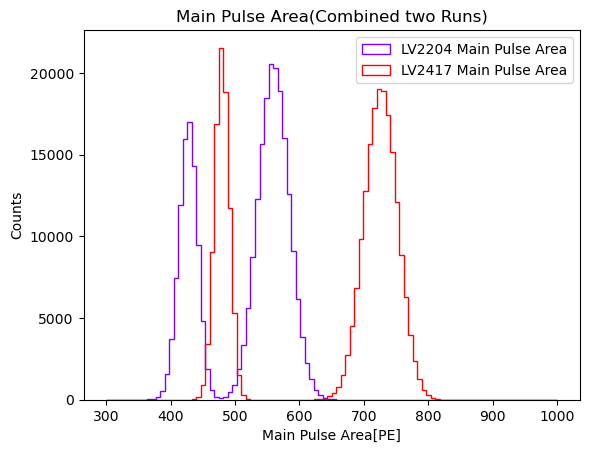

In [63]:
plt.hist(main_pulse_area_14/6.11, bins=100, range=(3.E2,1E3), histtype='step', color=cmp[0], label='LV2204 Main Pulse Area')
plt.hist(main_pulse_area_15/6.23, bins=100, range=(3.E2,1E3), histtype='step', color=cmp[6], label='LV2417 Main Pulse Area')
plt.xlabel('Main Pulse Area[PE]')
plt.ylabel('Counts')
plt.title('Main Pulse Area(Combined two Runs)')
plt.legend()
# plt.title('Main Pulse Area Ch14')
plt.show()

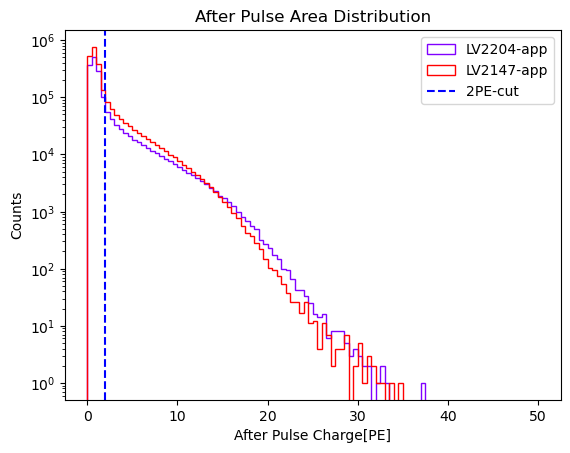

: 

In [112]:
plt.hist(all_filtered_app_14.area[all_filtered_app_14.pulse_index != 0]/6.11, bins=100, range=(0,50), histtype='step', color=cmp[0], label='LV2204-app')
plt.hist(all_filtered_app_15.area[all_filtered_app_15.pulse_index != 0]/6.23, bins=100, range=(0,50), histtype='step', color=cmp[6], label='LV2147-app')
plt.axvline(x=2, linestyle='--', color='b', label='2PE-cut')

plt.xlabel('After Pulse Charge[PE]')
plt.ylabel('Counts')
plt.legend()
plt.yscale('log')
plt.title('After Pulse Area Distribution')
plt.show()

In [111]:
main_pulse_width_14 = all_filtered_app_14.width[all_filtered_app_14.pulse_index == 0]
main_pulse_width_15 = all_filtered_app_15.width[all_filtered_app_15.pulse_index == 0]

main_pulse_start_14 = all_filtered_app_14.start[all_filtered_app_14.pulse_index == 0]
main_pulse_start_15 = all_filtered_app_15.start[all_filtered_app_15.pulse_index == 0]

main_pulse_min_14 = all_filtered_app_14.min_point[all_filtered_app_14.pulse_index == 0]
main_pulse_min_15 = all_filtered_app_15.min_point[all_filtered_app_15.pulse_index == 0]

# main_pulse_end_14 = all_filtered_app_14.end[all_filtered_app_14.pulse_index == 0]
# main_pulse_end_15 = all_filtered_app_15.end[all_filtered_app_15.pulse_index == 0]

main_pulse_hight_14 = all_filtered_app_14.height[all_filtered_app_14.pulse_index == 0]
main_pulse_hight_15 = all_filtered_app_15.height[all_filtered_app_15.pulse_index == 0]

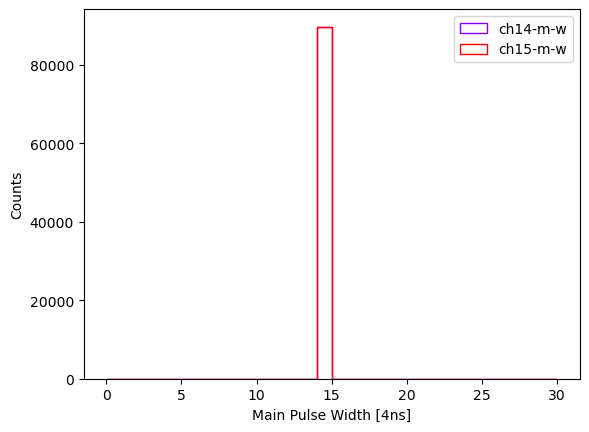

In [112]:
plt.hist(main_pulse_width_14, bins=30, range=(0,30), histtype='step', color=cmp[0], label='ch14-m-w')
plt.hist(main_pulse_width_15, bins=30, range=(0,30), histtype='step', color=cmp[6], label='ch15-m-w')
plt.xlabel('Main Pulse Width [4ns]')
plt.ylabel('Counts')
plt.legend()
# plt.yscale('log')
# plt.title('After Pulse Area Distribution')
plt.show()

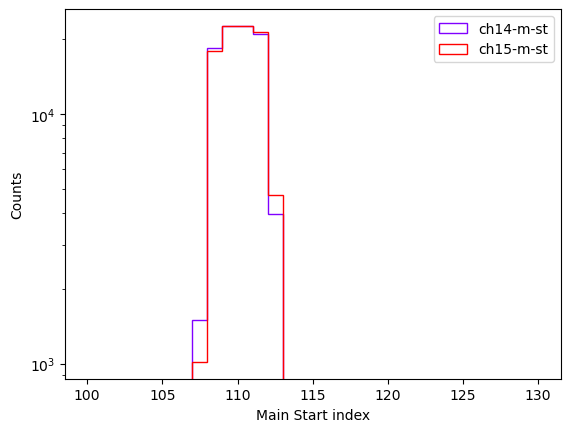

In [113]:
plt.hist(main_pulse_start_14, bins=30, range=(100,130), histtype='step', color=cmp[0], label='ch14-m-st')
plt.hist(main_pulse_start_15, bins=30, range=(100,130), histtype='step', color=cmp[6], label='ch15-m-st')
plt.xlabel('Main Start index')
plt.ylabel('Counts')
plt.legend()
plt.yscale('log')
# plt.title('After Pulse Area Distribution')
plt.show()

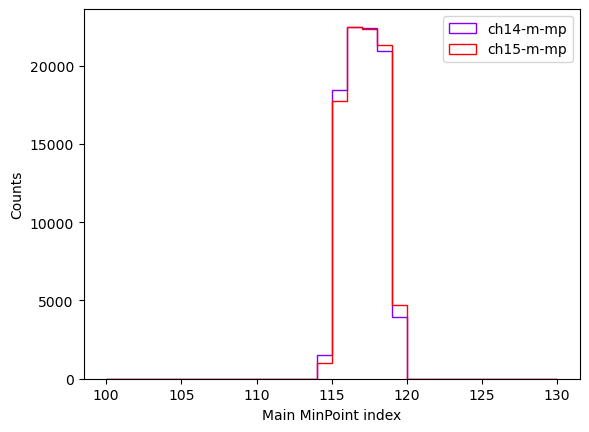

In [114]:
plt.hist(main_pulse_min_14, bins=30, range=(100,130), histtype='step', color=cmp[0], label='ch14-m-mp')
plt.hist(main_pulse_min_15, bins=30, range=(100,130), histtype='step', color=cmp[6], label='ch15-m-mp')
plt.xlabel('Main MinPoint index')
plt.ylabel('Counts')
plt.legend()
# plt.yscale('log')
# plt.title('After Pulse Area Distribution')
plt.show()

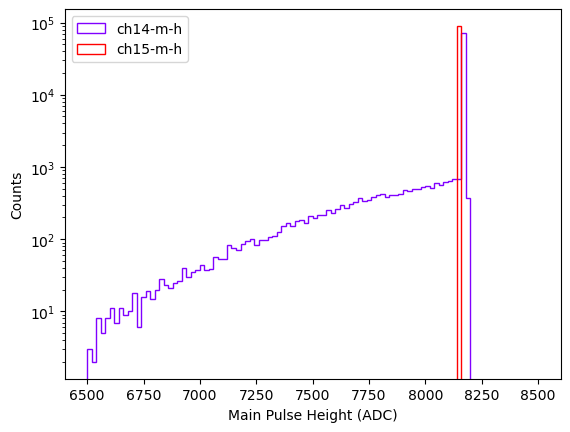

In [115]:
plt.hist(main_pulse_hight_14, bins=100, range=(6.5E3,8.5E3), histtype='step', color=cmp[0], label='ch14-m-h')
plt.hist(main_pulse_hight_15, bins=100, range=(6.5E3,8.5E3), histtype='step', color=cmp[6], label='ch15-m-h')
plt.xlabel('Main Pulse Height (ADC)')
plt.ylabel('Counts')
plt.legend()
plt.yscale('log')
# plt.title('After Pulse Area Distribution')
plt.show()

In [ ]:
evt_index = 1
# evt_index = 
pt.plot_waveform_from_df(df, evt_index, 80, 2000, title_str='')
# plt.ylim(6000,8500)